In [72]:
import pandas as pd
import numpy as np
import itertools
import random
import ast
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, wilcoxon, friedmanchisquare, kendalltau, pearsonr
from matplotlib import animation
from mpl_toolkits import mplot3d
from scipy.spatial import distance
from pyxdameraulevenshtein import damerau_levenshtein_distance

pd.set_option('display.max_rows', 500)

### Prepare Data

In [2]:
# read data

df = pd.read_csv('all_task_environments.csv', header=0, skiprows=[1])

### Define functions for prediction

In [3]:
def predict_sequence(objects, coordinates, start_coordinates, c, k, dimension=[3,]):
    ''' Predicts sequence based on required objects, object coordinates, start coordinates of subject,
        parameters (c+k) and dimensionality.
        Input: Objects, object coordinates, start coordinates, c, k, dimension
        Output: Sequence of objects as str
    '''
    prediction = []
    possible_items = dict.fromkeys(objects, 0) # generate dict from object list
    coord_index = 0
    start_coords = start_coordinates
    coords = coordinates
    new_coords = {}
    new_start_coords = []
    
    if dimension[0] == 3: # no changes if 3D
        new_coords = coords
        new_start_coords = start_coords
        
    elif dimension[0] == 2: # 2D: remove obsolete coordinate
        if dimension[1] == 'xy':
            new_coords = {key: value[:-1] for key, value in coords.items()}
            new_start_coords = [x[:-1] for x in start_coords]
                
        elif dimension[1] == 'xz':
            new_start_coords = [[x[0], x[-1]] for x in start_coords]
            
            for key, value in coords.items():
                new_value = (value[0], value[-1])
                new_coords[key] = new_value
        
        elif dimension[1] == 'yz':
            new_coords = {key: value[1:] for key, value in coords.items()}
            new_start_coords = [x[1:] for x in start_coords]
                
    elif dimension[0] == 1: # 1D: choose appropriate coordinate
        if dimension[1] == 'x':
            new_coords = {key: value[0] for key, value in coords.items()}
            new_start_coords = [x[0] for x in start_coords]
        
        elif dimension[1] == 'y':
            new_coords = {key: value[1] for key, value in coords.items()}
            new_start_coords = [x[1] for x in start_coords]
        
        elif dimension[1] == 'z':
            new_coords = {key: value[2] for key, value in coords.items()}
            new_start_coords = [x[2] for x in start_coords]
    
    while bool(possible_items) == True: # while dict not empty
        for obj in possible_items.keys():
            possible_items[obj] = ((distance.euclidean(
                                new_start_coords[coord_index], 
                                new_coords[obj])
                                ) ** k[obj]) * c[obj]
        #print(possible_items)                      
        minval = min(possible_items.values())
        minval = [k for k, v in possible_items.items() if v == minval]
        minval = random.choice(minval) # choose prediction randomly if multiple items have same cost
        prediction.append(minval)
        del possible_items[minval]
        coord_index += 1
        
    return prediction

In [4]:
def get_average(objects, coordinates, start_coordinates, c, k, dimension, sequence):
    ''' Returns average edit distance (Damerau-Levenshtein) for 100 trials of sequence prediction.
    '''
    edit_list = []

    for x in range(0,100):
        result = ''.join(predict_sequence(objects, coordinates, start_coordinates, c, k, dimension))
        dl = damerau_levenshtein_distance(sequence,result)
        edit_list.append(dl)
    
    avg = np.mean(edit_list)
    return avg

In [109]:
def get_avg_editdist(data):
    ''' Calculates average edit distance for all combinations of parameters (c, k, dimension).
        Input: Dataframe with objects, coordinates, start coordinates, object categories
        Output: Dataframe with edit distance results (col name: parameters used)
    '''
    results = pd.DataFrame()
    dimensions = [[1,'x'],[1,'y'],[1,'z'],[2,'xy'],[2,'xz'],[2,'yz'],[3,'xyz']]
        
    for row in range(0,len(df)):
        objects = list(df.at[row,'objects'].split(','))
        strong_k = list(df.at[row,'strong_k'].split(','))
        mid_k = list(df.at[row,'mid_k'].split(','))
        coordinates = {key: ast.literal_eval(value) for key, value in (elem.split(': ') for elem in df.at[row,'coordinates'].split(';'))}
        start_coordinates = list(ast.literal_eval(df.at[row, 'start_coordinates']))
        sequence = str(df.at[row,'sequence'])
        
        #for k in np.arange(0.0,1.0,0.1):
        for k in np.arange(0,0.9,0.1):
            k_strong = round(k,2)
            k_mid = round(k + 0.1,2)
            k1 = {obj: k_strong if obj in strong_k else k_mid if obj in mid_k else 1.0 for obj in objects}
                    
            for c in np.arange(1.0,2.0,0.1):
                c = round(c, 1)
                c1 = {obj: c if obj in df.at[row, 'containment'] else 1.0 for obj in objects}
                
                for dim in dimensions:                
                    # get average edit distance
                    edit_dist = get_average(objects, coordinates, start_coordinates, c1, k1, dim, sequence)
                    edit_dist = edit_dist / len(sequence)
                    
                    params = 'c: ' + str(c) + '; k: ' + str(k_strong) + ',' + str(k_mid) + '; ' + str(dim[1])
                    results.at[row,params] = edit_dist
                    
    return results

### Calculate edit distances, create df

In [6]:
#%%timeit -n1 -r1
results_new = get_avg_editdist(df)

In [7]:
results_new

c: 1.0; k: 0.0,0.1; x  c: 1.0; k: 0.0,0.1; y  c: 1.0; k: 0.0,0.1; z  \
0                0.400000               0.868000               0.684000   
1                0.412000               0.600000               0.694000   
2                0.410000               0.600000               0.694000   
3                0.568000               0.400000               0.400000   
4                0.326667               0.666667               0.666667   
5                0.700000               0.500000               0.800000   
6                0.812500               0.695000               0.795000   
7                0.760000               1.000000               0.707500   
8                0.146667               0.293333               0.420000   
9                0.163333               0.506667               0.143333   
10               0.700000               0.480000               0.712000   
11               0.741667               0.565000               0.718333   
12               0.640000               0.375000               0.585000   
13               0.728571               0.687143               0.791429   
14               0.733333               0.753333               0.696667   
15               0.881111               0.801111               0.763333   
16               0.694000               0.862000               0.830000   
17               0.220000               0.255000               0.250000   
18               0.672000               0.488000               0.894000   
19               0.702000               0.616000               0.590000   
20               0.170000               0.153333               0.513333   
21               0.405000               0.250000               0.632500   
22               0.510000               0.666667               0.516667   
23               0.362500               0.367500               0.617500   

    c: 1.0; k: 0.0,0.1; xy  c: 1.0; k: 0.0,0.1; xz  c: 1.0; k: 0.0,0.1; yz  \
0                 0.324000                0.192000                0.400000   
1                 0.200000                0.324000                0.600000   
2                 0.000000                0.186000                0.600000   
3                 0.200000                0.322000                0.400000   
4                 0.496667                0.333333                0.666667   
5                 0.588000                0.400000                0.308000   
6                 1.000000                0.730000                1.000000   
7                 1.000000                0.760000                1.000000   
8                 0.000000                0.163333                0.266667   
9                 0.333333                0.173333                0.333333   
10                0.600000                0.700000                0.600000   
11                0.556667                0.703333                0.533333   
12                0.370000                0.542500                0.367500   
13                0.704286                0.785714                0.695714   
14                0.756667                0.706667                0.745000   
15                0.881111                0.766667                0.762222   
16                0.844000                0.860000                0.800000   
17                0.290000                0.300000                0.260000   
18                0.508000                0.904000                0.508000   
19                0.600000                0.800000                0.800000   
20                0.000000                0.333333                0.143333   
21                0.250000                0.500000                0.250000   
22                0.666667                0.333333                0.666667   
23                0.250000                0.500000                0.387500   

    c: 1.0; k: 0.0,0.1; xyz  c: 1.1; k: 0.0,0.1; x  c: 1.1; k: 0.0,0.1; y  \
0                  0.000000               0.176000               0.552000   
1                  0.20

### Get lowest error, compare edit distances

In [130]:
def get_lowest_error(results):
    ''' Returns lowest error in dataframe and index of lowest error.
    '''
    for col in list(results):
        results.loc['mean',col] = results[col].mean()
    lowest = min(results.loc['mean'])
    mean = list(results.loc['mean'])
    
    return lowest, results.columns[(results.loc['mean'] == lowest)], mean, results

In [132]:
lowest, lowest_idx, list_mean, results_mean = get_lowest_error(results_new)
lowest, lowest_idx

(0.4151031746031746, Index(['c: 1.5; k: 0.4,0.5; xy'], dtype='object'))

In [122]:
mean_editdist = np.mean(list_mean)
print(mean_editdist)
print(np.mean(results_mean.loc['mean',:]))

0.5094750650877634
0.5094750650877634


In [118]:
# Compare avg edit distance for xy and xyz
list_xy = []
list_xyz = []

for col in results_mean:
    if col.split(';')[2].strip() == 'xy':
        list_xy.append(results_mean.at['mean',col])
    elif col.split(';')[2].strip() == 'xyz':
        list_xyz.append(results_mean.at['mean',col])
        
avg_xy = np.mean(list_xy)
median_xy = np.median(list_xy)
std_xy = np.std(list_xy)
print('Average xy: ' + str(avg_xy) + ', median: ' + str(median_xy)  + ', stdev: ' + str(std_xy))
        
avg_xyz = np.mean(list_xyz)
median_xyz = np.median(list_xyz)
std_xyz = np.std(list_xyz)
print('Average xyz: ' + str(avg_xyz) + ', median: ' + str(median_xyz) + ', stdev: ' + str(std_xyz))

Average xy: 0.4475619525279247, median: 0.44572056878306876, stdev: 0.01380558317693378
Average xyz: 0.4532700213109936, median: 0.45140906084656085, stdev: 0.014752792274571337


In [110]:
# Compare avg edit distances for x, y, z
list_x = []
list_y = []
list_z = []
list_xz = []
list_yz = []

for col in results_mean:
    if col.split(';')[2].strip() == 'x':
        list_x.append(results_mean.at['mean',col])
    elif col.split(';')[2].strip() == 'y':
        list_y.append(results_mean.at['mean',col])
    elif col.split(';')[2].strip() == 'z':
        list_z.append(results_mean.at['mean',col])
    elif col.split(';')[2].strip() == 'xz':
        list_xz.append(results_mean.at['mean',col])
    elif col.split(';')[2].strip() == 'yz':
        list_yz.append(results_mean.at['mean',col])

avg_xz = np.mean(list_xz)
avg_yz = np.mean(list_yz)
        
avg_x = np.mean(list_x)
lowest_x = min(list_x)
print('Average x: ' + str(avg_x) + ', min: ' + str(lowest_x)) 
        
avg_y = np.mean(list_y)
lowest_y = min(list_y)
print('Average y: ' + str(avg_y) + ', min: ' + str(lowest_y)) 
        
avg_z = np.mean(list_z)
lowest_z = min(list_z)
print('Average z: ' + str(avg_z) + ', min: ' + str(lowest_z)) 

print('Average xz: ' + str(avg_xz)) 
print('Average yz: ' + str(avg_yz)) 

Average x: 0.5005774360670193, min: 0.4895115740740741
Average y: 0.5319365924456202, min: 0.5009189814814815
Average z: 0.5939972846854791, min: 0.5736038359788361
Average xz: 0.5074120774544387
Average yz: 0.5315700911228689


### Statistical analysis

In [75]:
# correlate avg edit distance with volume of environment space

dimensions_error = [avg_x, avg_y, avg_z, avg_xy, avg_xz, avg_yz, avg_xyz]
dimensions_volume = [1.889,3.1667,1.8333,6.5556,3.5,6.0556,12.5556]
dimensions_volume_corr = [1.889,3.1667,1.8333,6.5556,3.5,6.0556,19.1111]
#volumes_z 

corr, p = spearmanr(dimensions_error, dimensions_volume)
print('Spearman dims: \u03C1 = %.3f, p = %.15f' % (corr, p))

means = list(results_mean.loc['mean',:])
dimensions_vol = dimensions_volume * 90
dimensions_vol_corr = dimensions_volume_corr * 90

corr, p = spearmanr(means, dimensions_vol)
print('Spearman dims: \u03C1 = %.3f, p = %.20f' % (corr, p))

corr, p = spearmanr(means, dimensions_vol_corr)
print('Spearman dims corrected: \u03C1 = %.3f, p = %.20f' % (corr, p))

Spearman dims: ρ = -0.714, p = 0.071343561467538
Spearman dims: ρ = -0.708, p = 0.00000000000000000000
Spearman dims corrected: ρ = -0.708, p = 0.00000000000000000000


In [152]:
cm = ['red','blue','green','magenta','cyan','orange','grey']
dim_num = [0 if x=='x' else 1 if x=='y' else 2 if x=='z' else 3 if x=='xy' else 4 if x=='xz' else 5 if x=='yz' else 6 for x in dim]
cmap = matplotlib.colors.ListedColormap(cm)

fig = plt.figure(figsize=(12,8))
img = plt.scatter(means, dimensions_vol, alpha=0.5, c=dim_num, cmap=cmap)
plt.plot(np.unique(means), np.poly1d(np.polyfit(means, dimensions_vol, 1))(np.unique(means)), color='black')
plt.ylabel('volume of environment', fontsize=25, labelpad=10)
plt.xlabel('avg. edit distance', fontsize=25, labelpad=10)

# create legend
plt.legend(('x','y','z','xy','xz','yz','xyz'), scatterpoints=7, fontsize=18)

plt.show()

In [149]:
cm = ['red','blue','green','magenta','cyan','orange','grey']
dim_num = [0 if x=='x' else 1 if x=='y' else 2 if x=='z' else 3 if x=='xy' else 4 if x=='xz' else 5 if x=='yz' else 6 for x in dim]
cmap = matplotlib.colors.ListedColormap(cm)

fig = plt.figure(figsize=(12,8))
plt.scatter(list_x, dimen)

[0, 1, 2, 3, 4, 5, 6]

In [22]:
# Compare all error predictions for dimensions
stat, p = friedmanchisquare(list_x,list_y,list_z,list_xy,list_xz,list_yz,list_xyz)
print('Friedman: stat = %.3f, p = % 10.3E' % (stat, p))

Friedman: stat = 511.486, p =  2.820E-107


In [111]:
# compare individual dimensions (error predictions)

# 2D
print('2D:')
corr, p = spearmanr(list_x, list_xy)
print('Spearman x: \u03C1 = %.3f, p = %.15f' % (corr, p))

corr, p = spearmanr(list_y, list_xy)
print('Spearman y: \u03C1 = %.3f, p = %.15f' % (corr, p))

corr, p = kendalltau(list_y, list_xy)
print('Kendall: \u03C4 b = %.3f, p = %.15f' % (corr, p))

# 3D
print('3D:')
corr, p = spearmanr(list_x, list_xyz)
print('Spearman x: \u03C1 = %.3f, p = %.15f' % (corr, p))

corr, p = spearmanr(list_y, list_xyz)
print('Spearman y: \u03C1 = %.3f, p = %.15f' % (corr, p))

corr, p = spearmanr(list_z, list_xy)
print('Spearman z: \u03C1 = %.3f, p = %.15f' % (corr, p))

# 2D vs 3D
print('2D vs 3D:')
stat, p = wilcoxon(list_xy, list_xyz, zero_method='wilcox')
print('Wilcoxon: W = %.3f, p = %.3f' % (stat, p))

stat, p = wilcoxon(list_xy, list_xyz, zero_method='wilcox', alternative='less')
print('Wilcoxon: W = %.3f, p = %.3f' % (stat, p))

2D:
Spearman x: ρ = 0.127, p = 0.232560116661718
Spearman y: ρ = 0.448, p = 0.000009421421155
Kendall: τ b = 0.300, p = 0.000028417958911
3D:
Spearman x: ρ = -0.330, p = 0.001497799655866
Spearman y: ρ = -0.036, p = 0.737992071913454
Spearman z: ρ = 0.462, p = 0.000004537140209
2D vs 3D:
Wilcoxon: W = 1302.000, p = 0.003
Wilcoxon: W = 1302.000, p = 0.001


### Plots

In [14]:
# Define input for plots

c = [float(x[3:6]) for x in results_new.columns.tolist()]
k = [float(x[11:14]) for x in results_new.columns.tolist()]
dim = [x.strip() for x in results_new.columns.str.split(';').str[2]]
error = results_mean.loc['mean'].tolist()

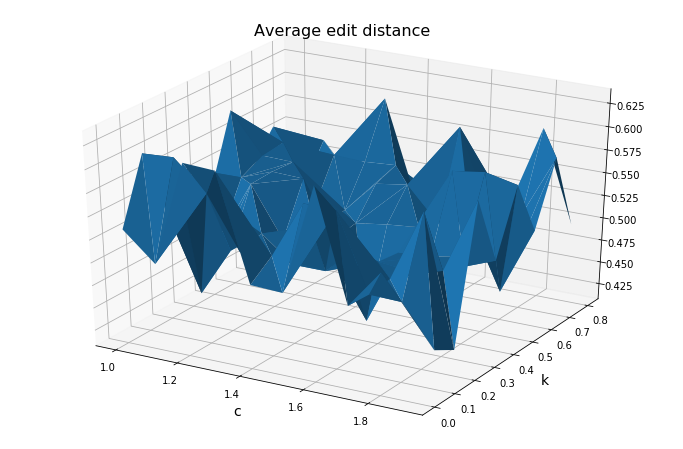

In [12]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')

ax.plot_trisurf(c, k, error, linewidth=0.2)
ax.set_ylabel('k', fontsize=14, labelpad=7)
ax.set_xlabel('c', fontsize=14, labelpad=7)
plt.title('Average edit distance', fontsize=16)
plt.show()

In [108]:
#%matplotlib qt

cm = ['red','blue','green','magenta','cyan','orange','grey']
dim_num = [0 if x=='x' else 1 if x=='y' else 2 if x=='z' else 3 if x=='xy' else 4 if x=='xz' else 5 if x=='yz' else 6 for x in dim]

cmap = matplotlib.colors.ListedColormap(cm)

ticks = ['x', 'y', 'z', 'xy', 'xz', 'yz', 'xyz']
norm = matplotlib.colors.BoundaryNorm(ticks, cmap.N)

# create figure, 3d grid, set background to white
fig2 = plt.figure(figsize=(12,8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.w_xaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax2.w_yaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax2.w_zaxis.set_pane_color((1.0,1.0,1.0,1.0))

# create plot
img = ax2.scatter(c, k, error, alpha=0.5, s=38, c=dim_num, cmap=cmap)

# plot horizontal plane for baseline
xx, yy = np.meshgrid(np.linspace(1,1.9), np.linspace(0,0.9))
#yy = np.meshgrid(range(2), range(2))
zz = xx * 0 + 0.603
ax2.plot_surface(xx, yy, zz, alpha=0.5)

# set labels
ax2.set_ylabel('parameter k', fontsize=20, labelpad=10)
ax2.set_xlabel('parameter c', fontsize=20, labelpad=10)
ax2.set_zlabel('normalized edit distance', fontsize=20, labelpad=7)
#plt.title('Average edit distance (1 step)', fontsize=24)

# create colorbar
cb = plt.colorbar(img, cax = fig2.add_axes([0.9,0.3,0.03,0.4]))
cb.ax.set_yticklabels(ticks, fontsize=16)
plt.show()

In [15]:
# generate rotating image

fig3 = plt.figure(figsize=(12,8))
ax3 = mplot3d.Axes3D(fig3)
ax3.w_xaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax3.w_yaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax3.w_zaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax3.set_ylabel('parameter k', fontsize=14, labelpad=7)
ax3.set_xlabel('parameter c', fontsize=14, labelpad=7)
ax3.set_zlabel('normalized edit distance', fontsize=14, labelpad=7)

def init():
    ax3.scatter(c, k, error, alpha=0.5, s=38, c=dim_num, cmap=cmap)
    
    return fig,

def animate(i):
    ax3.view_init(elev=10, azim=i*4)
    return fig,

animated = animation.FuncAnimation(fig3, animate, init_func=init, frames=90, interval=50, blit=True)

In [284]:
# save animated fig

plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

fig_name = 'rotate_model_lowesterror_3D'
#animated.save(fig_name+'.gif', writer='imagemagick', fps=1000/50)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, bitrate=10000)
animated.save(fig_name+'.mp4', writer=writer)